# Binning challenges in structure functions

The idea behind this notebook would be to see if a 'rolling' structure function could be applied, and how it would improve the ts derived and binning

## 1. Initialisation

Libraries and paths

In [1]:
# Libraries

import sys
import os

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from   scipy.signal      import savgol_filter
from   itertools         import product
from   tqdm              import tqdm

sys.path.append('../../Benchmark_QM/Packages')
sys.path.append('../../GaiaDR3_study/Packages')


from   Handy             import get_files_paths
from   Handy             import amp_595

import SyntheticCurves   as     Sc
import StructureFunction as     SF

In [2]:
#Paths
path_init   = os.path.expanduser('~')
path        = get_files_paths(path_init + '/M2/Codes/GaiaDR3_study/paths.txt')
filepath    = path['synthetic_dr3']
path_obs_w  = path['dr3_obs_window']

## 2. Synthetic light curves

- Get Gaia DR3 sampling from one of the catalog's source
- Define a grid of parameters
- Create a bunch of light curves with a periodic signal from the grid

The parameters are : 
- Period $P$,
- 5-95 amplitude $A$, 
- median magnitude $mag_{med}$,
- Gaussian noise.

The magnitude at time t is :
\begin{equation}
mag = mag_{med} + \frac{A}{2} \sin{(2 \pi P t)} + noise
\end{equation}

In [3]:
# Get Gaia sampling

ID        = 761
band      = 'G'
path_star = path['gaia_data'] + f'/Nemesis_{ID}.csv'
star      = pd.read_csv(path_star, delimiter=',')
times     = np.array(star[f'Time{band}'])
times     = times[~np.isnan(times)]

In [4]:
# Parameter grid
periods   = [0.5, 3, 13, 23, 101]  #days
amps      = [0.2, 0.7, 1]          #mag
medmags   = [10, 12, 15]            #mag
sigs      = [0.001, 0.01, 0.03]

param_grid = {'periods' : periods, 'amps' : amps, 'medmags' : medmags, 'sigs' : sigs}

#Colors definition
colors  = ['cornflowerblue', 'indianred', 'midnightblue','darkred', 'mediumslateblue']

In [5]:
#Synthetic light curve
def sine(period, amp, med_mag, sig, times) :
    noise    = np.random.normal(0, sig, len(times))
    mag      = med_mag + amp/2 * np.sin(2 * np.pi * (times - min(times))/period) + noise
    return mag

In [6]:
# make all the lc
parameter_combinations = [(p, a, m, s) \
                          for p in periods for a in amps for m in medmags for s in sigs]
lc_dict = {}

for params in parameter_combinations:
    
    period, amp, med_mag, sig = params
    
    mag_synt = sine(period, amp, med_mag, sig, times)
    
    # Store the light curve in the dictionary with a label based on parameters
    label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
    lc_dict[label] = {'time': times, 'mag': mag_synt}


In [7]:
period, amp, med_mag, sig = periods[2], amps[1], medmags[1], sigs[0]
label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
mag   = lc_dict[label]['mag']

## 3. Structure function

In [138]:
'''
This package computes the Structure function as implemented by Sergison+19 and Venuti+21, in order to apply it to GaiaDR3 data
'''

#################################
#Libraries

import numpy             as     np
import pandas            as     pd


def structure_function_slow(mag, time, num_bins = 100, epsilon = 0) :
    """
    Calculate the structure function of a magnitude time series using a slow method.

    Parameters:
    - mag, time (numpy.ndarray): magnitudes and times of the light curve
    - interp : if False, no interpolation is made and a discrete SF is returned
    - num_bins : number of bins for time_bins
    - epsilon : tolerence threshold (min nb of pairs required for a bin) 

    Returns:
    - sf (numpy.ndarray): The calculated structure function
    - time_bins (numpy.ndarray): corresponding log-spaced time bins.
    """
    
    tmin, tmax = min(np.diff(time)), max(time)-min(time)
    
    # Create logarithmically spaced time bins
    log_bins  = np.logspace(np.log10(tmin), np.log10(tmax), num=num_bins+1, endpoint=True, base=10.0)
    time_bins = (log_bins[:-1] + log_bins[1:]) / 2.0

    sf       = np.zeros(len(time_bins))
    it_list  = []

    #Compute all time lags, corresponding delta_mags
    delta_t_  = []
    delta_mag = []
    
    for i in range(len(time)):
        for j in range(i+1, len(time)):
            dt = abs(time[i] - time[j])
            delta_t_.append(dt)
            delta_mag.append((mag[i] - mag[j])**2)
            
    delta_t_  = np.array(delta_t_)
    delta_mag = np.array(delta_mag)
    
    sort      = np.argsort(delta_t_)
    delta_t_, delta_mag = delta_t_[sort], delta_mag[sort]
    
    #Loop to adjust the time bins to have at least epsilon pairs per time bin :
    for i, time_bin in enumerate(time_bins) :
        
        bin_diff_d = abs(time_bin - log_bins[i])
        bin_diff_u = abs(time_bin - log_bins[i+1])

        lags_ind   = np.where((delta_t_>time_bin-bin_diff_d) & \
                              (delta_t_<time_bin+bin_diff_u))[0]
        
        
        while len(lags_ind) < epsilon :
            
            if len(lags_ind) == 0 :
                break
            
            bin_diff_d += 0.05*bin_diff_d
            bin_diff_u += 0.05*bin_diff_d
        
            lags_ind    = np.where((delta_t_>time_bin-bin_diff_d) & \
                                  (delta_t_<time_bin+bin_diff_u))[0]
            #print(len(lags_ind))  
        if len(lags_ind)>0 :
            sf[i] = 1/len(lags_ind) * sum(delta_mag[lags_ind])

        else :
            sf[i] = np.nan
            
        it_list.append(len(lags_ind))

    #Remove nan
    sel                     = ~np.isnan(sf)
    sf_sel, time_lag_sel    = sf[sel], np.array(time_bins)[sel]
    it_list                 = np.array(it_list)[sel]
    
    return sf_sel, time_lag_sel, np.array(it_list)
    
def structure_function_roll(mag, time, num_bins = 100, epsilon = 1) :
    """
    Calculate the structure function of a magnitude time series. 
    The structure function at each time is evaluated on a 'rolling' fashion

    Parameters:
    - mag, time (numpy.ndarray): magnitudes and times of the light curve
    - interp : if False, no interpolation is made and a discrete SF is returned
    - num_bins : number of bins for time_bins
    - epsilon : tolerence threshold

    Returns:
    - sf (numpy.ndarray): The calculated structure function
    - time_bins (numpy.ndarray): corresponding log-spaced time bins.
    """
    
    tmin, tmax = min(np.diff(time)), max(time)-min(time)
    
def find_timescale(sf, tau):
    """
    Find the timescale corresponding to the first peak or plateau in the structure function.

    Parameters:
    - sf, tau (numpy.ndarray): The Structure function.

    Returns:
    - timescale (int): The timescale corresponding to the first peak or plateau.
    """
    
    slope     = np.gradient(sf)
    signs     = np.sign(slope)
    
    peaks = []
    for i, sign in enumerate(signs) :  #find a better way to compute this
        if i>=2 :
            if (sign == -1 or sign == 0) and signs[i-1] == 1:# and signs[i-2] == 1 :
                peaks.append(i)
                
    tau_high = np.array(tau)[peaks]   
    ind_tau  = np.where(tau_high > 0.7)[0][0]

    return tau_high[ind_tau]


In [139]:
num_bins        = len(times)
epsilon         = 42
sf, t_log, it   = structure_function_slow(np.array(mag), np.array(times-min(times)),\
                                        num_bins = num_bins, epsilon = epsilon)
ts              = find_timescale(sf, t_log)

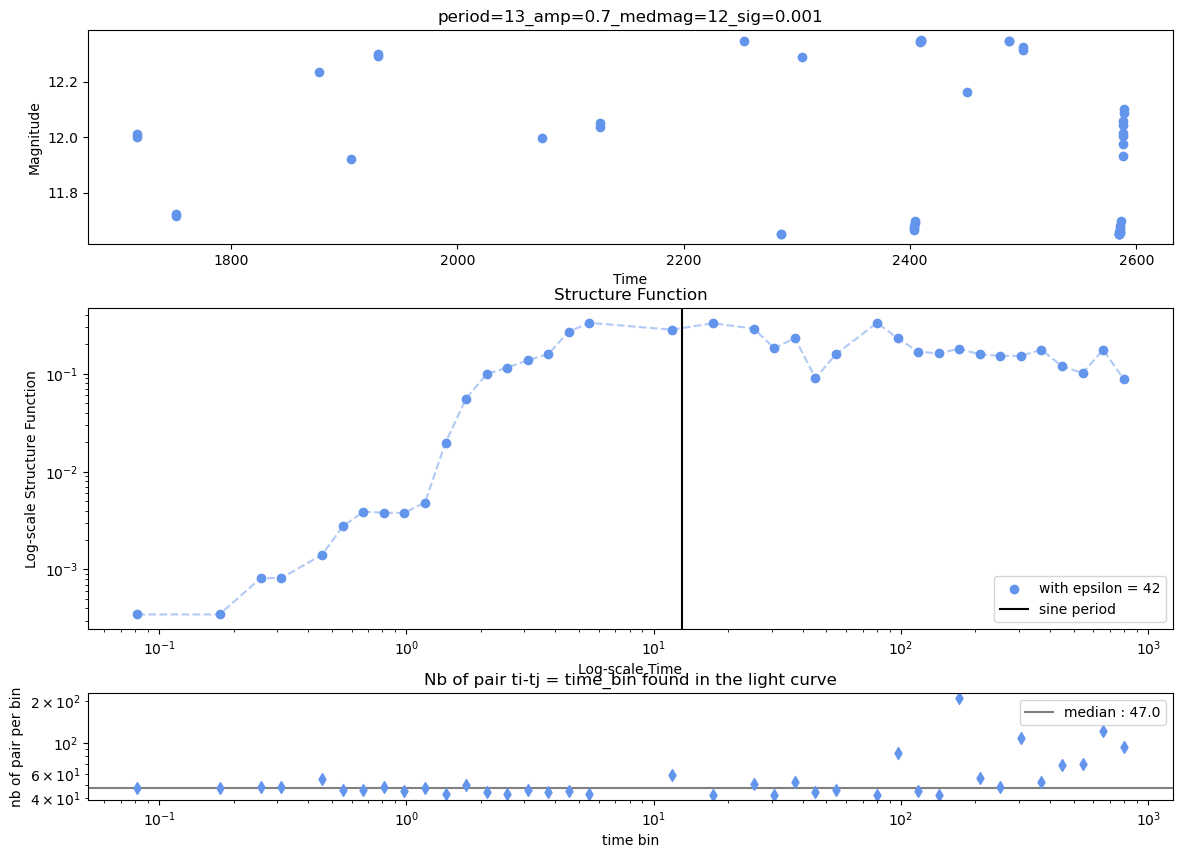

In [140]:
i = 0
fig, ax = plt.subplots(3, 1, figsize=(14, 10),\
          gridspec_kw={'height_ratios': [2, 3, 1], 'hspace': 0.3})

ax[0].scatter(times, mag, c=colors[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Magnitude')
ax[0].set_title(label)

ax[1].scatter(t_log, sf, label=f'with epsilon = {epsilon}', c=colors[i])
ax[1].plot(t_log, sf, linestyle='--', c=colors[i], alpha=0.5)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Log-scale Time')
ax[1].set_ylabel('Log-scale Structure Function')
ax[1].set_title('Structure Function')
ax[1].axvline(period, c = 'black', label = 'sine period')
ax[1].legend(loc='lower right')

#Nb of pairs found for each
ax[2].scatter(t_log, it, c =colors[i], marker = 'd')
ax[2].set_xlabel('time bin')
ax[2].set_ylabel('nb of pair per bin')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Nb of pair ti-tj = time_bin found in the light curve')
ax[2].axhline(np.median(it), c = 'grey', zorder = 0, label = f'median : {np.round(np.median(it), 2)}')
ax[2].legend()

plt.show()

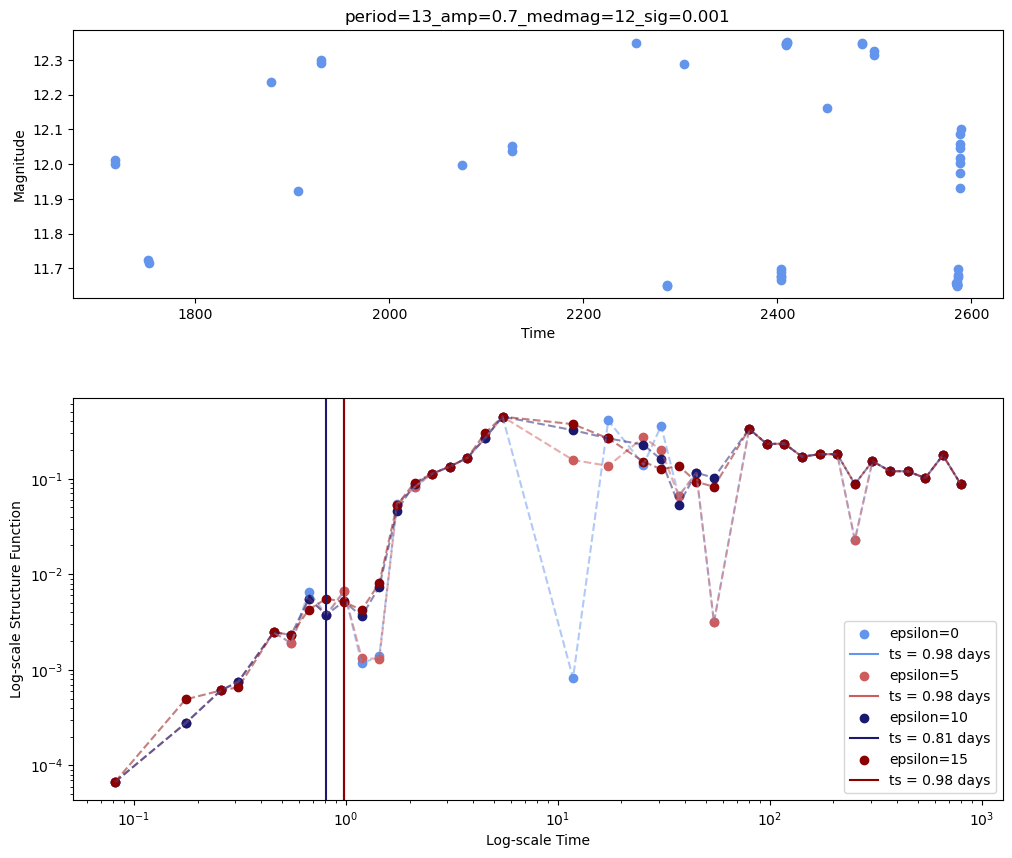

In [141]:
epsilon_list = [0, 5, 10, 15]

fig, ax = plt.subplots(2, 1, figsize=(12, 10),\
          gridspec_kw={'height_ratios': [2, 3], 'hspace': 0.3})


#Light curve
period, amp, med_mag, sig = periods[2], amps[1], medmags[1], sigs[0]
label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
mag   = lc_dict[label]['mag']

#plot lc
ax[0].scatter(times, mag, c=colors[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Magnitude')
ax[0].set_title(label)

#SF with num_bins varying
for i, epsilon in enumerate(epsilon_list) :

    sf, t_log, it   = structure_function_slow(np.array(mag), np.array(times-min(times)),\
                                                   num_bins = len(times), epsilon = epsilon)
    ts              = find_timescale(sf, t_log)
    
    # Plot sf
    ax[1].scatter(t_log, sf, label=f'epsilon={epsilon}', c=colors[i])
    ax[1].plot(t_log, sf, linestyle='--', c=colors[i], alpha=0.5)
    ax[1].axvline(ts, label = f'ts = {np.round(ts, 2)} days', c = colors[i])

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Log-scale Time')
ax[1].set_ylabel('Log-scale Structure Function')
ax[1].legend(loc='lower right')

plt.show()